## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
# model
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Embedding, LSTM, Dense
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Upload data

In [48]:
# load data
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/My Drive/projects/22: Splash/data'
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/projects/22: Splash/data
cna_covid.csv         fake.csv       simple.h5        straits_pol.csv
cna_cri.csv           nfn_model.h5   straits_con.csv  straits_tra.csv
cna_ent.csv           onion_ent.csv  straits_cou.csv  true.csv
cna_health.csv        onion_loc.csv  straits_env.csv
cna_sus.csv           onion_new.csv  straits_hea.csv
Constraint_Train.csv  onion_pol.csv  straits_job.csv


## Exploring datasets

In [3]:
# load fake datasets
kaggle_fake = pd.read_csv('fake.csv')
onion_ent = pd.read_csv('onion_ent.csv')
onion_loc = pd.read_csv('onion_loc.csv')
onion_new = pd.read_csv('onion_new.csv')
onion_pol = pd.read_csv('onion_pol.csv')

# load true datasets
kaggle_true = pd.read_csv('true.csv')
cna_cov = pd.read_csv('cna_covid.csv')
cna_cri = pd.read_csv('cna_cri.csv')
cna_ent = pd.read_csv('cna_ent.csv')
cna_hea = pd.read_csv('cna_health.csv')
cna_sus = pd.read_csv('cna_sus.csv')
straits_con = pd.read_csv('straits_con.csv')
straits_cou = pd.read_csv('straits_cou.csv')
straits_env = pd.read_csv('straits_env.csv')
straits_hea = pd.read_csv('straits_hea.csv')
straits_job = pd.read_csv('straits_job.csv')
straits_pol = pd.read_csv('straits_pol.csv')
straits_tra = pd.read_csv('straits_tra.csv')

In [4]:
kaggle_true.drop(kaggle_true.tail(18000).index, inplace=True)
kaggle_fake.drop(kaggle_fake.tail(18000).index, inplace=True)

In [5]:
kaggle_fake.describe()

,title,text,subject,date
count,5481,5481,5481,5481
unique,5480,5481,1,528
top,McConnell Says He’ll Obstruct ANY Effort To H...,Donald Trump just couldn t wish all Americans ...,News,"January 25, 2017"
freq,2,1,5481,23


In [6]:
onion = pd.concat([onion_ent, onion_loc, onion_new, onion_pol])
cna = pd.concat([cna_cov, cna_cri, cna_ent, cna_hea, cna_sus])
straits = pd.concat([straits_con, straits_cou, straits_env, straits_hea, straits_job, straits_pol, straits_tra])

In [7]:
# remove unnecessary columns
onion = onion.drop(['Link', 'Title'], axis=1)
onion['text'] = onion['Content']
onion = onion.drop(['Content'], axis=1)

In [8]:
cna = cna.drop(['Link', 'Title'], axis=1)
cna['text'] = cna['Content']
cna = cna.drop(['Content'], axis=1)

In [9]:
straits = straits.drop(['Link', 'Title'], axis=1)
straits['text'] = straits['Content']
straits = straits.drop(['Content'], axis=1)

In [10]:
kaggle_fake = kaggle_fake.drop(['subject', 'title', 'date'], axis=1)
kaggle_true = kaggle_true.drop(['subject', 'title', 'date'], axis=1)

In [11]:
fake = pd.concat([kaggle_fake, onion])
true = pd.concat([kaggle_true, cna, straits])

In [12]:
fake.head()

,text
0,Donald Trump just couldn t wish all Americans ...
1,House Intelligence Committee Chairman Devin Nu...
2,"On Friday, it was revealed that former Milwauk..."
3,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis used his annual Christmas Day mes...


In [13]:
true.head()

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [14]:
# label datasets
fake['label'] = 1
true['label'] = 0

In [15]:
# merge both datasets
df = pd.concat([fake, true])

# randomly shuffle rows
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

df.head(10)

,text,label
0,"On New Jersey 101.5, Chris Christie made the a...",1
1,"My fellow Singaporeans, We have battled Covid-...",0
2,A pawn working for Donald Trump claimed that w...,1
3,"WADSWORTH, OH—Wanting to detect any danger bef...",1
4,(Reuters) - U.S. President Donald Trump is exp...,0
5,WASHINGTON (Reuters) - The lawyer for former U...,0
6,Late Show host Stephen Colbert has been having...,1
7,SINGAPORE: A fugitive couple allegedly involve...,0
8,BRUSSELS (Reuters) - The United States cannot ...,0
9,This should have been a red flag.As we all kno...,1


## Preparing data

In [16]:
# checking info of datasets
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12537 non-null  object
 1   label   12537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 196.0+ KB


,label
count,12537.000000
mean,0.520140
std,0.499614
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [17]:
# delete duplicates if any
df.drop_duplicates(subset=None, keep='first', inplace=True)
df.reset_index(inplace=True, drop=True)

df.describe()

,label
count,11541.000000
mean,0.481847
std,0.499692
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


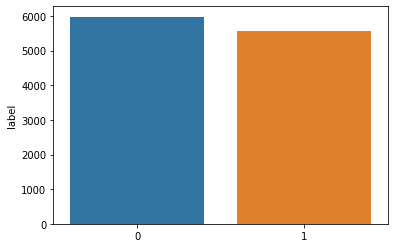

In [18]:
# plotting class distribution
x = df['label'].value_counts()
sns.barplot(x.index, x)

## Text processing

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [20]:
def clean(sentence):
  sentence = sentence.lower()
  sentence = sentence.replace('https://', ' ')
  sentence = sentence.replace('http://', ' ')
  sentence = re.sub('[^a-zA-Z0-9 ]', ' ', sentence)

  sentence = " ".join(sentence.split())

  '''
  filtered = []
  for word in sentence.split():
    if word not in stop_words or word == "not" or word == "never":
      filtered.append(word)
  
  sentence = " ".join(filtered)
  '''
  
  sentence = "".join([lemmatizer.lemmatize(word) for word in sentence])

  return sentence

In [21]:
df['clean_text'] = df['text'].apply(lambda x: clean(x))
df.head()

,text,label,clean_text
0,"On New Jersey 101.5, Chris Christie made the a...",1,on new jersey 101 5 chris christie made the ar...
1,"My fellow Singaporeans, We have battled Covid-...",0,my fellow singaporeans we have battled covid 1...
2,A pawn working for Donald Trump claimed that w...,1,a pawn working for donald trump claimed that w...
3,"WADSWORTH, OH—Wanting to detect any danger bef...",1,wadsworth oh wanting to detect any danger befo...
4,(Reuters) - U.S. President Donald Trump is exp...,0,reuters u s president donald trump is expected...


In [22]:
corpus = [text for text in df['clean_text']]
corpus[0]

'on new jersey 101 5 chris christie made the argument for raising wages for judges and government employees but he still presumably thinks minimum wage workers and teachers are the exceptions christie lost a bid to get a raise for judges who currently make 140 000 a year in new jersey according to christie 140k makes for stupid judges the idea somehow that judges are overpaid is ridiculous christie said christie said starting salaries for lawyers in the new jersey area is 195 000 for a first year associate you don t want judges out there lawyers becomes judges who think that getting 140 000 a year is a raise christie said if you can t make 140 000 as a lawyer with the experience to actually be on the bench you re not that good a lawyer you want to appear before stupid judges then don t raise their pay anymore because the people you will get in the main applying for these jobs will be people who see it as a step up in pay for them said christie here s the video christie was referring to

In [23]:
one_hot_encoded = [one_hot(text, 10000) for text in corpus]
m = max([len(text) for text in one_hot_encoded])
m

5292

In [24]:
emb_doc = tf.keras.preprocessing.sequence.pad_sequences(
    one_hot_encoded, 
    maxlen=m, 
    padding="pre"
)

In [25]:
l = np.array(emb_doc)
l

array([[   0,    0,    0, ..., 4006, 4788, 8673],
       [   0,    0,    0, ..., 2593, 8521, 6137],
       [   0,    0,    0, ..., 9252, 3158, 1279],
       ...,
       [   0,    0,    0, ..., 2890, 6384, 4177],
       [   0,    0,    0, ...,  372, 4340, 5618],
       [   0,    0,    0, ..., 9987, 5348, 9187]], dtype=int32)

## Model training

In [38]:
model = Sequential()
model.add(Embedding(10000, 64, input_length=m))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="acc"
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5292, 64)          640000    
                                                                 
 dropout_2 (Dropout)         (None, 5292, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               328704    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


In [39]:
# splitting dataset
x_train, x_test, y_train, y_test = train_test_split(
    np.array(emb_doc),
    df['label'],
    random_state=0,
    test_size=0.3
)

x_test

array([[   0,    0,    0, ..., 4813, 4788, 8673],
       [   0,    0,    0, ..., 9252, 4788, 8673],
       [   0,    0,    0, ..., 3990, 4788, 8673],
       ...,
       [   0,    0,    0, ..., 9527, 2498, 3664],
       [   0,    0,    0, ..., 7625, 5854, 5467],
       [   0,    0,    0, ..., 7521, 8521, 5526]], dtype=int32)

In [40]:
# fit model
hist = model.fit(
    x_train, 
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10
)

Epoch 1/10
202/202 [==============================] - 57s 275ms/step - loss: 0.1611 - acc: 0.9673 - val_loss: 0.0541 - val_acc: 0.9876
Epoch 2/10
202/202 [==============================] - 56s 277ms/step - loss: 0.0393 - acc: 0.9895 - val_loss: 0.0502 - val_acc: 0.9864
Epoch 3/10
202/202 [==============================] - 55s 272ms/step - loss: 0.0182 - acc: 0.9946 - val_loss: 0.0525 - val_acc: 0.9864
Epoch 4/10
202/202 [==============================] - 56s 277ms/step - loss: 0.0111 - acc: 0.9968 - val_loss: 0.0612 - val_acc: 0.9851
Epoch 5/10
202/202 [==============================] - 56s 278ms/step - loss: 0.0027 - acc: 0.9991 - val_loss: 0.0777 - val_acc: 0.9839
Epoch 6/10
202/202 [==============================] - 55s 272ms/step - loss: 5.9016e-04 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9827
Epoch 7/10
202/202 [==============================] - 56s 277ms/step - loss: 2.4787e-04 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9814
Epoch 8/10
202/202 [===========================

In [41]:
hist.history

{'loss': [0.16113123297691345,
  0.03931114822626114,
  0.01821565441787243,
  0.01114311721175909,
  0.002718389732763171,
  0.0005901626427657902,
  0.0002478723181411624,
  0.0014456728240475059,
  0.0001349493395537138,
  5.962685463600792e-05],
 'acc': [0.9673475623130798,
  0.9894769191741943,
  0.9945837259292603,
  0.9967502355575562,
  0.999071478843689,
  1.0,
  1.0,
  0.9996904730796814,
  1.0,
  1.0],
 'val_loss': [0.054103147238492966,
  0.05018928647041321,
  0.05250734090805054,
  0.0612039677798748,
  0.07773146033287048,
  0.08480051904916763,
  0.09073878079652786,
  0.07815910130739212,
  0.09048867970705032,
  0.09717538207769394],
 'val_acc': [0.9876237511634827,
  0.9863861203193665,
  0.9863861203193665,
  0.9851484894752502,
  0.9839109182357788,
  0.9826732873916626,
  0.9814356565475464,
  0.9839109182357788,
  0.9832921028137207,
  0.9832921028137207]}

Text(0.5, 1.0, 'Accuracy')

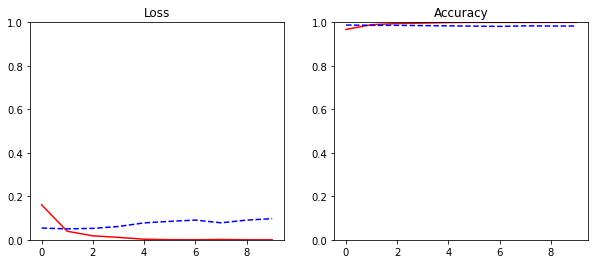

In [42]:
# loss-accuracy visualisation
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], color="red")
plt.plot(hist.history['val_loss'], color="blue", linestyle="--")
plt.ylim(0, 1)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], color="red")
plt.plot(hist.history['val_acc'], color="blue", linestyle="--")
plt.ylim(0, 1)
plt.title("Accuracy")

## Model evaluation

In [43]:
# check predictions
prediction = model.predict(x_test)
y_prediction = np.where(prediction > 0.5, 1, 0)

In [44]:
model.evaluate(y_test, y_prediction)

109/109 [==============================] - 1s 3ms/step - loss: 0.5615 - acc: 0.9856


[0.5615355372428894, 0.9855616688728333]

In [45]:
print(f"Accuracy score: {metrics.accuracy_score(y_test, y_prediction)}")
print(f"Confusion matrix: {metrics.confusion_matrix(y_test, y_prediction)}")
print(metrics.classification_report(y_test, y_prediction))

Accuracy score: 0.9855616517470401
Confusion matrix: [[1797    5]
 [  45 1616]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1802
           1       1.00      0.97      0.98      1661

    accuracy                           0.99      3463
   macro avg       0.99      0.99      0.99      3463
weighted avg       0.99      0.99      0.99      3463



## Saving model

In [47]:
model.save('nfn_model.h5')